In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

In [2]:
scores = pd.read_csv("TCGA_all_signatures_v2.csv", index_col=0, header=0)
remove_barcodes = ['TCGA-BL-A13J-01B-04R-A277-07',
                   'TCGA-BL-A13J-01A-11R-A10U-07',
                   'TCGA-BL-A13I-01A-11R-A277-07',
                   'TCGA-BL-A13I-01B-04R-A277-07']
scores = scores.loc[~scores.index.isin(remove_barcodes)]
barcodes = ['-'.join(b.split('-')[:3]) for b in scores.index]
scores.index = barcodes

### Download the TCGA clinical data resource

Save the first worksheet as `TCGA_cdr.csv`

https://gdc.cancer.gov/about-data/publications/PanCan-Clinical-2018

In [3]:
TCGA_cdr = pd.read_csv("TCGA_cdr.csv", index_col='bcr_patient_barcode', header=0)
cols = [
    'type', 'OS', 'OS.time', 'DSS', 'DSS.time'
]
BLCA_cdr = TCGA_cdr.loc[TCGA_cdr['type']=='BLCA', cols]
BLCA_cdr = BLCA_cdr.loc[scores.index, :]

In [4]:
# Create data for KM plots
event_col = 'DSS'
time_col = 'DSS.time'

rm_rows = pd.isna(BLCA_cdr[event_col]) | pd.isna(BLCA_cdr[time_col])

event = BLCA_cdr.loc[~rm_rows, event_col] == 1
time = np.array(BLCA_cdr.loc[~rm_rows, time_col], dtype=np.float32) / 365

km_data = scores.loc[~rm_rows, :].copy()
km_data['Event'] = event
km_data['Time'] = time

km_data

,ACTA2_Fibroblast_signature_ssGSEA,APC_Macrophage_signature_ssGSEA,Activated_Bcell_signature_ssGSEA,CDH12_CDH18_Epithelial_signature_ssGSEA,DSG3_Epithelial_signature_ssGSEA,Dendritic_cell_signature_ssGSEA,Endothelial_broad_signature_ssGSEA,Endothelial_signature_ssGSEA,FAP_Fibroblast_signature_ssGSEA,Fibroblast_signature_ssGSEA,...,proliferation_visium_ssGSEA,stromal2_visium_ssGSEA,stromal_visium_ssGSEA,time_0_signature_ssGSEA,time_1_signature_ssGSEA,time_2_signature_ssGSEA,time_3_signature_ssGSEA,time_4_signature_ssGSEA,Event,Time
TCGA-ZF-AA4U,0.361674,0.601706,0.347066,-0.102050,0.636966,0.454244,0.549345,0.492249,0.496363,0.532047,...,0.397467,0.669477,0.438029,0.064429,0.360434,0.622570,0.677658,0.711738,True,0.717808
TCGA-G2-AA3C,0.426020,0.603103,0.361506,-0.026752,0.602482,0.496146,0.561073,0.524842,0.585608,0.589679,...,0.418296,0.735445,0.543459,0.116815,0.518848,0.525460,0.555789,0.536999,True,0.578082
TCGA-FD-A3SM,0.472011,0.629118,0.394142,0.024748,0.636852,0.487881,0.596392,0.536065,0.672239,0.652105,...,0.412448,0.764675,0.589074,0.162064,0.538087,0.595819,0.665393,0.672666,True,1.498630
TCGA-XF-A8HG,0.317410,0.599543,0.324610,-0.121717,0.553954,0.449134,0.490848,0.455746,0.465001,0.513069,...,0.400778,0.657440,0.414192,0.041867,0.337943,0.630442,0.725098,0.722867,True,1.279452
TCGA-FD-A6TE,0.370384,0.632115,0.358898,-0.111239,0.627479,0.471216,0.511900,0.466909,0.526811,0.551293,...,0.416971,0.694374,0.447040,0.035281,0.363645,0.611122,0.693393,0.696142,False,1.030137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UY-A78P,0.463938,0.647598,0.410425,0.017357,0.688783,0.516160,0.587153,0.536140,0.650643,0.622428,...,0.440891,0.760034,0.586386,0.148333,0.525179,0.595596,0.625646,0.656764,False,6.520548
TCGA-ZF-A9RF,0.406257,0.621247,0.371470,-0.054144,0.605280,0.506435,0.518940,0.478892,0.575597,0.586201,...,0.419109,0.696514,0.515161,0.070086,0.452006,0.540308,0.600388,0.599617,False,5.339726
TCGA-FD-A3B8,0.665422,0.688938,0.507444,0.105855,0.675608,0.585061,0.662090,0.614593,0.721408,0.727476,...,0.400950,0.855562,0.776581,0.226903,0.708588,0.598581,0.634578,0.627496,False,1.052055
TCGA-FD-A43P,0.431729,0.663508,0.436572,0.018803,0.588625,0.539337,0.551315,0.512883,0.621180,0.606772,...,0.465622,0.712604,0.526314,0.160884,0.472814,0.580311,0.665559,0.684486,False,2.279452


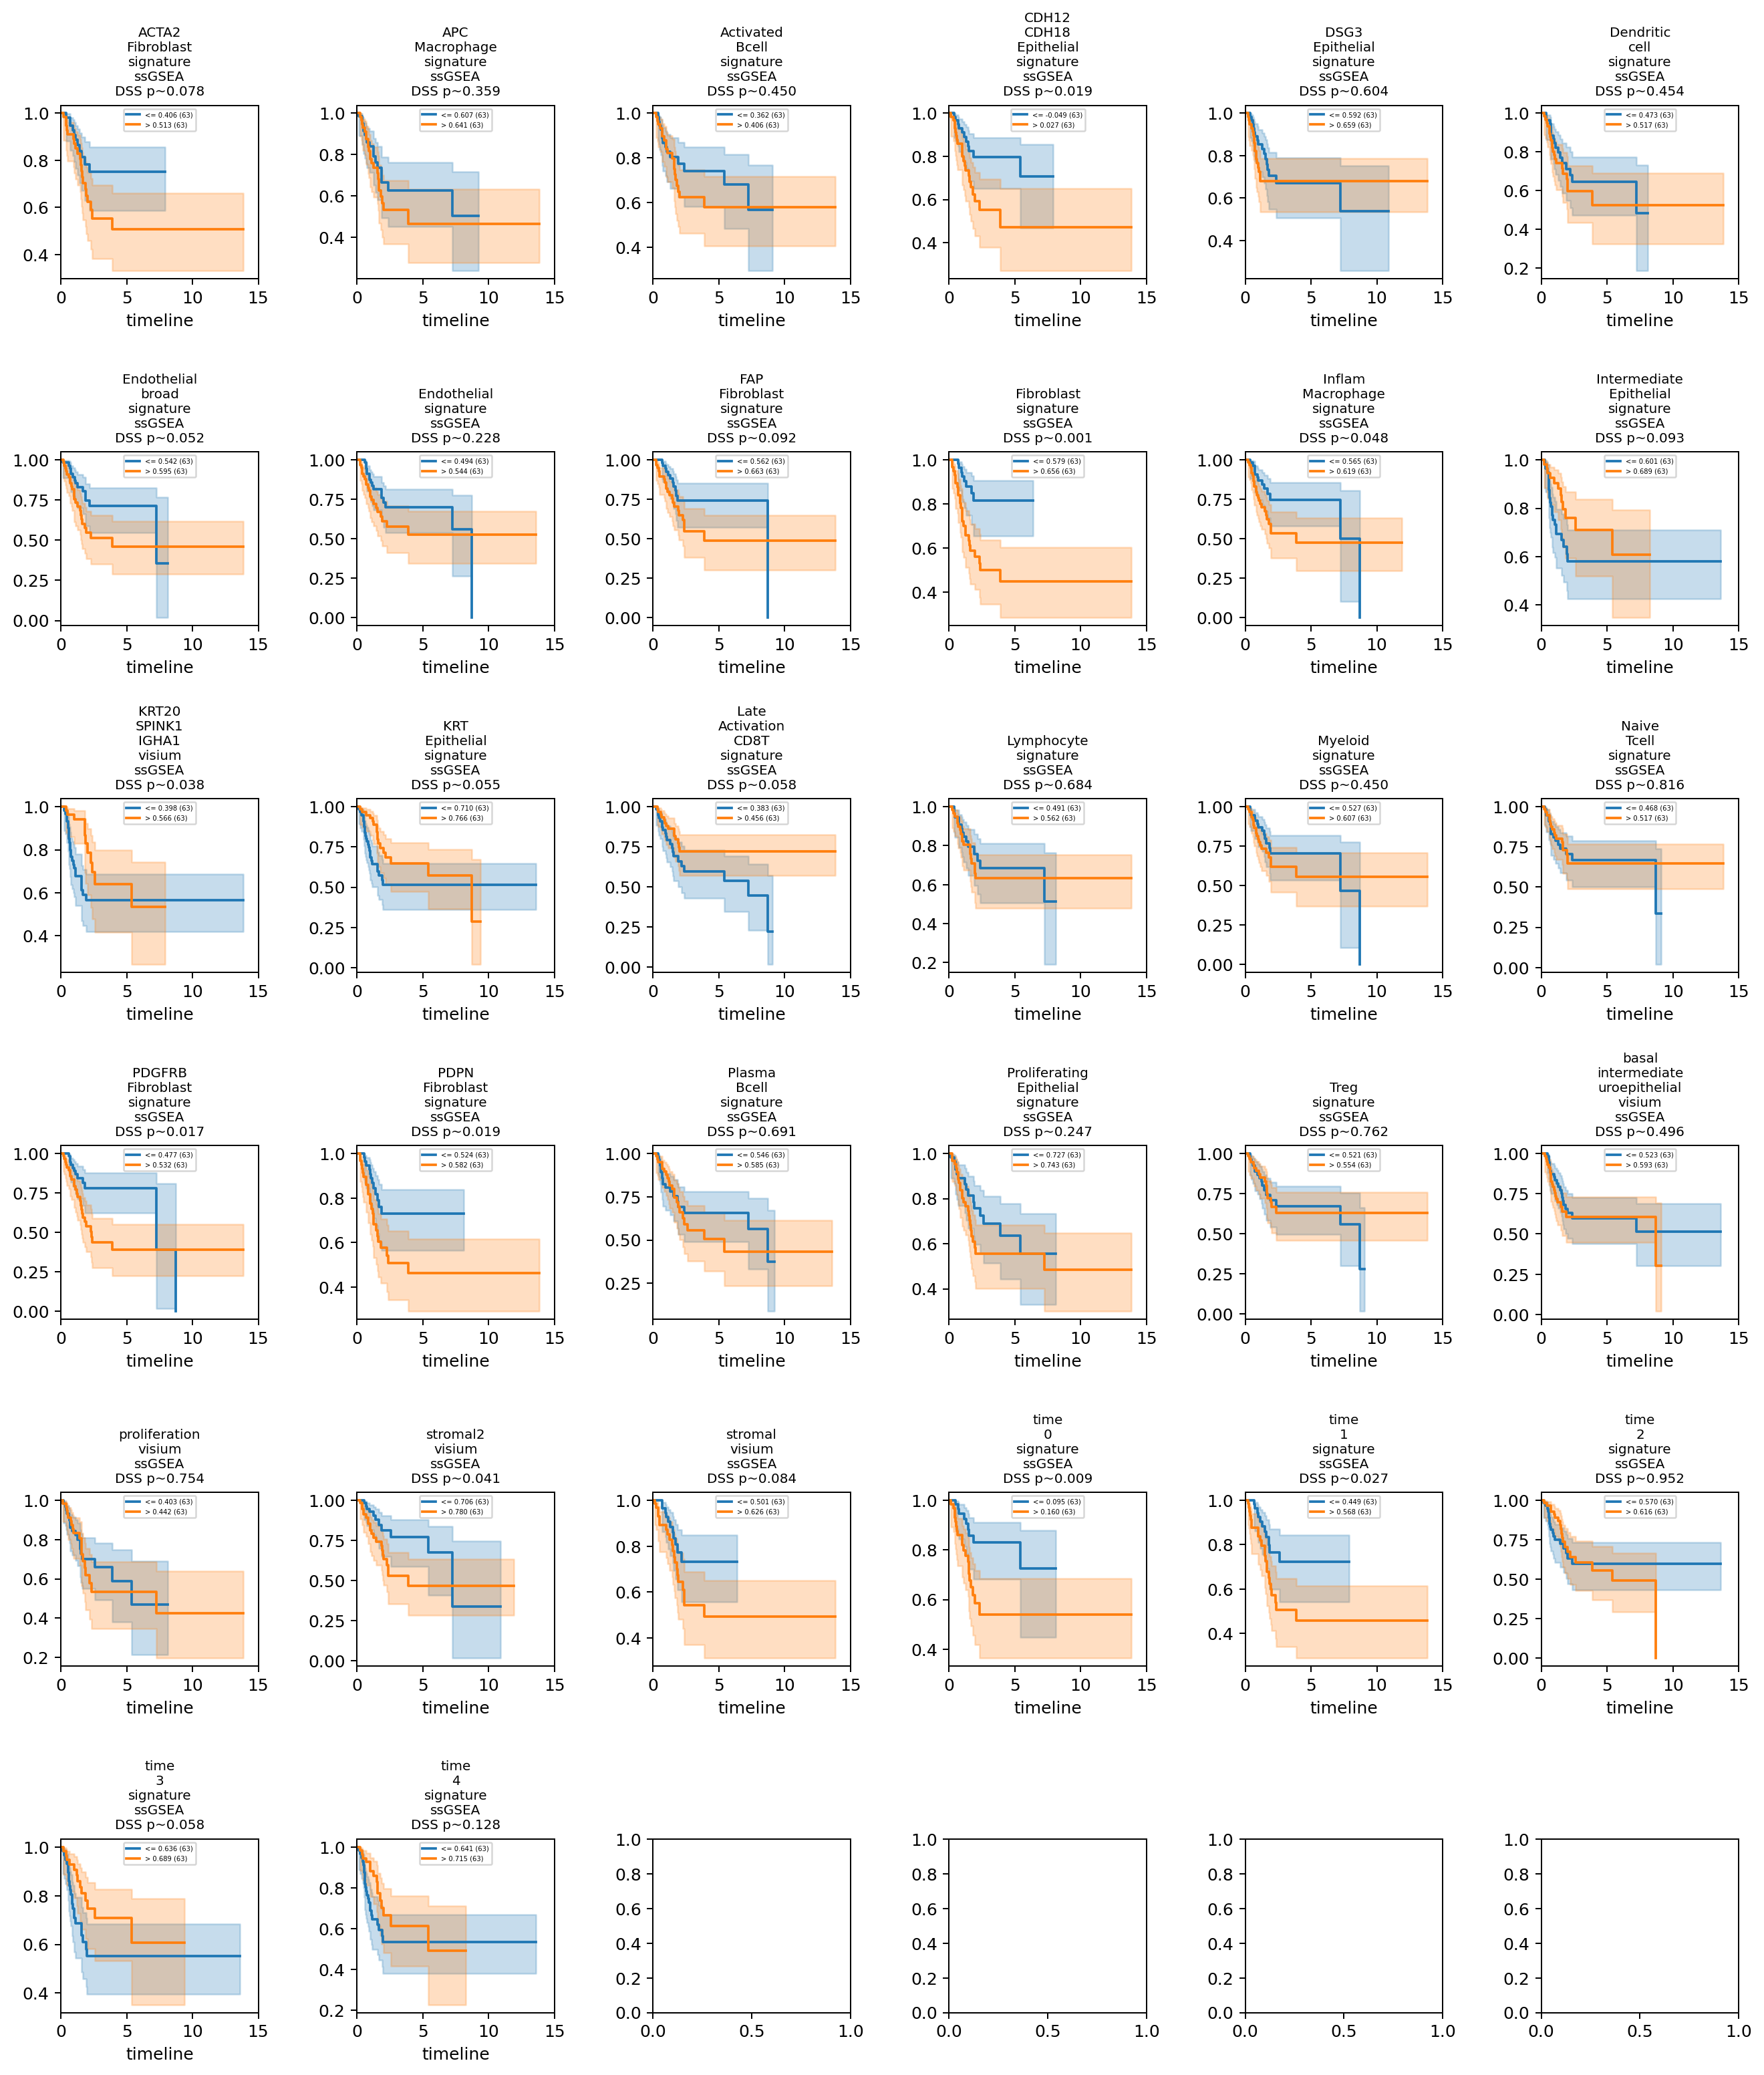

In [5]:
fig, axs = plt.subplots(6,6, figsize=(18, 21), dpi=180, gridspec_kw=dict(hspace=1, wspace=0.5))
axs = axs.ravel()
for c, ax in zip(scores.columns, axs):
    c_vals = km_data.loc[:, c].values
    q25, q75 = np.quantile(c_vals, [0.25, 0.75])
    g25 = c_vals <= q25
    g75 = c_vals > q75
    n25 = g25.sum()
    n75 = g75.sum()

    T1 = km_data.loc[g25, 'Time']
    E1 = km_data.loc[g25, 'Event']
    T2 = km_data.loc[g75, 'Time']
    E2 = km_data.loc[g75, 'Event']
    
    kmf = KaplanMeierFitter()
    kmf.fit( T1, E1, label=f'<= {q25:0.3f} ({n25})')
    kmf.plot(ax = ax)
    kmf.fit( T2, E2, label=f'> {q75:0.3f} ({n75})')
    kmf.plot(ax = ax)

    res = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
    ax.set_xlim([0, 15])
    c_title = c.replace('_', '\n')
    ax.set_title(f'{c_title}\n{event_col} p~{res.p_value:3.3f}', fontsize=8)
    ax.legend(loc='upper center', fontsize=4)